In [1]:
from __future__ import division
import time
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from PIL import Image
from scipy.misc import toimage
from cs231n.data_utils import load_CIFAR10

import os.path
import os
from tensorflow.python.framework import ops

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")
X_train= mnist.train.images.reshape([-1,28,28,1])
y_train= mnist.train.labels
X_test = mnist.test.images.reshape([-1,28,28,1])
y_test= mnist.test.labels
X_val=mnist.validation.images.reshape([-1,28,28,1])
y_val= mnist.validation.labels

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Train data shape:  (55000, 28, 28, 1)
Train labels shape:  (55000,)
Validation data shape:  (5000, 28, 28, 1)
Validation labels shape:  (5000,)
Test data shape:  (10000, 28, 28, 1)
Test labels shape:  (10000,)


In [3]:
from lasso_codes.lasso import lasso_fista
#from lasso_codes.lasso import lasso_fista_col
from lasso_codes.lasso import compute_lasso_grad
#from lasso_codes.lasso import compute_lasso_grad_col2

In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, X_val=None,y_val=None):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    


    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    total_correct=[]
    total_loss=[]
    total_loss_val=[]
    total_correct_val=[]
    iter_cnt = 0
    for e in range(epochs):
        # shuffle indicies
        train_indicies = np.arange(Xd.shape[0])
        np.random.shuffle(train_indicies)
    
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct.append(correct/Xd.shape[0])
        total_loss.append(np.sum(losses)/Xd.shape[0])
        if training:
            print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss[-1],total_correct[-1],e+1))
            [total_loss_tmp, total_correct_tmp]=run_model(session,predict,loss_val,X_val,y_val,1,batch_size)
            total_loss_val.append(total_loss_tmp[-1])
            total_correct_val.append(total_correct_tmp[-1])
        else:
            print("(Validation) Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss[-1],total_correct[-1],e+1))
            
        
        if plot_losses:
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(12,4))

            ax1.plot(losses)
            ax1.grid(True)
            ax1.set_title('Epoch {} Loss'.format(e+1))
            ax1.set_xlabel('minibatch number')
            ax1.set_ylabel('minibatch loss')
            
            ax2.plot(list(range(1,len(total_loss)+1)), total_loss, list(range(1,len(total_loss)+1)), total_loss_val)
            ax2.grid(True)
            ax2.set_title('Epoch {} Loss'.format(e+1))
            ax2.set_xlabel('epoch')
            ax2.set_ylabel('epoch loss')
            ax2.legend(['Training','Validation'],loc="upper right")
            
            ax3.plot(list(range(1,len(total_loss)+1)), total_correct, list(range(1,len(total_loss)+1)), total_correct_val)
            ax3.grid(True)
            ax3.set_title('Epoch {} Accuracy'.format(e+1))
            ax3.set_xlabel('epoch')
            ax3.set_ylabel('epoch accuracy')
            ax3.legend(['Training','Validation'],loc="upper left")
            
            f.tight_layout()
            plt.show()
            
    if training:
        return total_loss,total_correct, total_loss_val, total_correct_val
    else:
        return total_loss,total_correct

In [5]:
def simple_model(X,y,is_training):
    dtype=tf.float32
    #--------------------------------------------------------------
    def DDL_layer(X=X, dims=[25,28,28,1], ksizes=[1,3,3,1], dict_depth=10,
                  strides=[1,1,1,1], lambda1=0.01, padding='SAME', name='Layer1'):
        
        bsize=dims[0]
        rates=[1,1,1,1]
    
        @ops.RegisterGradient("LassoFistaGrad"+name)
        def _lasso_fista_identity_grad(op, grad):
            Dg = op.inputs[0]
            Xg = op.inputs[1]
            lambda1g=op.inputs[2]
            Ag = op.inputs[3]
            [lambda_grad, X_grad, D_grad]= compute_lasso_grad(X=Xg, A=Ag, D=Dg, lambda1=lambda1g, grad_output=grad,
                                                        ksizes=ksizes, strides=strides, rates=rates,
                                                          padding=padding, params=dims,NonNeg=True)

            lambda_grad=tf.expand_dims(lambda_grad,0)
            A_grad=grad
            lambda_grad=None
            return[D_grad, X_grad, lambda_grad, A_grad,None,None,None,None, None]
    
        g = tf.get_default_graph()
        with g.gradient_override_map({"LassoFista"+name : "LassoFistaGrad"+name }):
            with tf.variable_scope(name) as scope:
                _module=tf.load_op_library('lasso_codes/lasso_grad/lasso_fista_'+ name +'.so') #tf.sysconfig.get_lib()+

                D=tf.get_variable("Dict"+name, shape=[(ksizes[1]*ksizes[2]*dims[3]),dict_depth],dtype=dtype)
        
                A_tmp, _= lasso_fista(Dict=D,
                     input=X,
                     lambda1=lambda1,
                     ksizes=ksizes,
                     strides=strides,
                     rates=rates,
                     padding=padding,
                     maxItr=500,
                     NonNeg=True,
                     debug=False,
                     name="lasso"+ name)
                
      
                if (padding=='VALID'):
                    pad=0
                else:
                    pad=1
                
                lasso_fista_layer=getattr(_module, 'lasso_fista_'+ name.lower())
                A_n =lasso_fista_layer(D, X, lambda1, A_tmp, ksizes, strides, rates, pad, dims)
                A= A_n + tf.stop_gradient(A_tmp-A_n)
                if(padding=='SAME'):
                    h_o = int(np.ceil(float(dims[1]) / float(strides[1])))
                    w_o = int(np.ceil(float(dims[2]) / float(strides[2]))) 
                else:
                    h_o = int(np.ceil(float(dims[1] - ksizes[1] + 1) / float(strides[1])))
                    w_o  = int(np.ceil(float(dims[2] - ksizes[2] + 1) / float(strides[2])))
                
                A.set_shape([dims[0],h_o,w_o,dict_depth])
        return(A)
    
    #-----------------------------------------------------------------
    bsize=10
    A1=DDL_layer(X=X, dims=[bsize,28,28,1], ksizes=[1,3,3,1],
                 dict_depth=10, strides=[1,1,1,1], lambda1=0.1, padding='SAME',name='Layer1')
    
    bn1 = tf.layers.batch_normalization(
        inputs=A1,
        axis=-1,
        momentum=0.9,
        epsilon=0.001,
        center=True,
        scale=True,
        trainable=True,
        training = is_training,
        name='bn1')
    
    A2=DDL_layer(X=bn1, dims=[bsize,28,28,10], ksizes=[1,3,3,1],
                 dict_depth=20, strides=[1,2,2,1], lambda1=0.1, padding='SAME',name='Layer2')
    
    bn2 = tf.layers.batch_normalization(
        inputs=A2,
        axis=-1,
        momentum=0.9,
        epsilon=0.001,
        center=True,
        scale=True,
        trainable=True,
        training = is_training,
        name='bn2')
    
    A3=DDL_layer(X=bn2, dims=[bsize,14,14,20], ksizes=[1,3,3,1],
                 dict_depth=40, strides=[1,1,1,1], lambda1=0.1, padding='SAME',name='Layer3')
    
    bn3 = tf.layers.batch_normalization(
        inputs=A3,
        axis=-1,
        momentum=0.9,
        epsilon=0.001,
        center=True,
        scale=True,
        trainable=True,
        training = is_training,
        name='bn3')
    
    A4=DDL_layer(X=bn3, dims=[bsize,14,14,40], ksizes=[1,3,3,1],
                 dict_depth=40, strides=[1,2,2,1], lambda1=0.1, padding='SAME',name='Layer4')
    
    bn4 = tf.layers.batch_normalization(
        inputs=A4,
        axis=-1,
        momentum=0.9,
        epsilon=0.001,
        center=True,
        scale=True,
        trainable=True,
        training = is_training,
        name='bn4')

    M1= tf.layers.max_pooling2d(
        inputs=bn4,
        pool_size=[2,2],
        strides=[2,2],
        padding='SAME',
        data_format='channels_last',
        name='M1'
    )
    
    bn5 = tf.layers.batch_normalization(
        inputs=M1,
        axis=-1,
        momentum=0.9,
        epsilon=0.001,
        center=True,
        scale=True,
        trainable=True,
        training = is_training,
        name='bn5')
    
    A1_dense=tf.reshape(bn5,[bsize,-1])

    W1=tf.get_variable("Wclass1", shape=[(4*4*40),200],dtype=dtype)
    b1=tf.get_variable("b1", shape=[1,200],dtype=dtype)
    f1=tf.nn.relu(tf.matmul(a=A1_dense, b=W1)+b1)
    
    bn6 = tf.layers.batch_normalization(
        inputs=f1,
        axis=-1,
        momentum=0.9,
        epsilon=0.001,
        center=True,
        scale=True,
        trainable=True,
        training = is_training,
        name='bn6')
    
    d1=tf.layers.dropout(
        inputs=bn6,
        rate=0.6,
        name='d1')
    
    W2=tf.get_variable("Wclass2", shape=[200,10],dtype=dtype)
    b2=tf.get_variable("b2", shape=[1,10],dtype=dtype)
    y_out=tf.nn.relu(tf.matmul(a=d1, b=W2)+b2)



    #grad_D = tf.gradients(loss, D1)
    #grad_X = tf.gradients(loss, X)
    #grad_lambda1 = tf.gradients(loss, lambda1)
    return(y_out)

In [6]:
# Define the Graph
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool)
X= tf.placeholder(tf.float32, [None,28,28,1])
y= tf.placeholder(tf.int64,[None])
y_out=simple_model(X,y,is_training)

#### For trubleshooting

In [7]:
#with tf.device('/device:GPU:0'):
#    feed_dict = {X: X_train[0:10,:],
#             is_training: True }    
#    sess = tf.Session()
#    sess.run(tf.global_variables_initializer())

#    variables=y_out
#    out_np = sess.run(variables,feed_dict=feed_dict)
#print(out_np.shape)

In [8]:
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
#mean_loss = tf.reduce_mean(total_loss) + tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(1e-4) # select optimizer and set learning rate

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

#y_onehot=tf.one_hot(y, 10)
#y_onehot=tf.cast(y_onehot,tf.float32)
#err=y_onehot-y_out
#loss=tf.norm(err,2)

Training
Iteration 0: with minibatch training loss = 2.49 and accuracy of 0.2
Iteration 100: with minibatch training loss = 2.73 and accuracy of 0.2
Iteration 200: with minibatch training loss = 1.82 and accuracy of 0.4
Iteration 300: with minibatch training loss = 1.35 and accuracy of 0.7
Iteration 400: with minibatch training loss = 0.991 and accuracy of 0.6
Iteration 500: with minibatch training loss = 0.564 and accuracy of 0.9
Iteration 600: with minibatch training loss = 0.491 and accuracy of 0.8
Iteration 700: with minibatch training loss = 0.412 and accuracy of 0.9
Iteration 800: with minibatch training loss = 0.278 and accuracy of 1
Iteration 900: with minibatch training loss = 0.385 and accuracy of 0.9
Iteration 1000: with minibatch training loss = 0.349 and accuracy of 0.9
Iteration 1100: with minibatch training loss = 0.228 and accuracy of 0.9
Iteration 1200: with minibatch training loss = 1.37 and accuracy of 0.6
Iteration 1300: with minibatch training loss = 0.0811 and acc

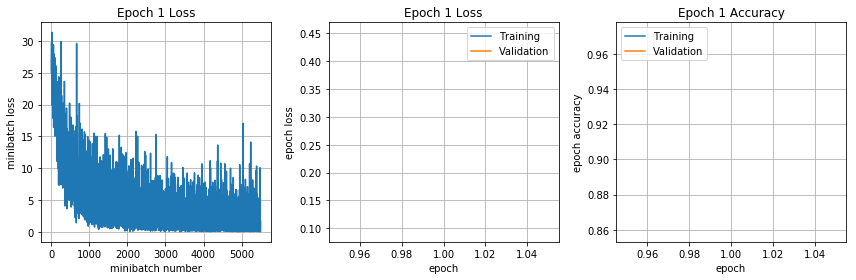

Iteration 5500: with minibatch training loss = 0.43 and accuracy of 0.9
Iteration 5600: with minibatch training loss = 0.273 and accuracy of 0.9
Iteration 5700: with minibatch training loss = 0.0322 and accuracy of 1
Iteration 5800: with minibatch training loss = 0.161 and accuracy of 0.9
Iteration 5900: with minibatch training loss = 0.223 and accuracy of 0.8
Iteration 6000: with minibatch training loss = 0.00693 and accuracy of 1
Iteration 6100: with minibatch training loss = 0.0259 and accuracy of 1
Iteration 6200: with minibatch training loss = 0.48 and accuracy of 0.9
Iteration 6300: with minibatch training loss = 0.0232 and accuracy of 1
Iteration 6400: with minibatch training loss = 0.139 and accuracy of 1
Iteration 6500: with minibatch training loss = 0.0878 and accuracy of 1
Iteration 6600: with minibatch training loss = 0.195 and accuracy of 0.9
Iteration 6700: with minibatch training loss = 0.122 and accuracy of 0.9
Iteration 6800: with minibatch training loss = 0.0384 and a

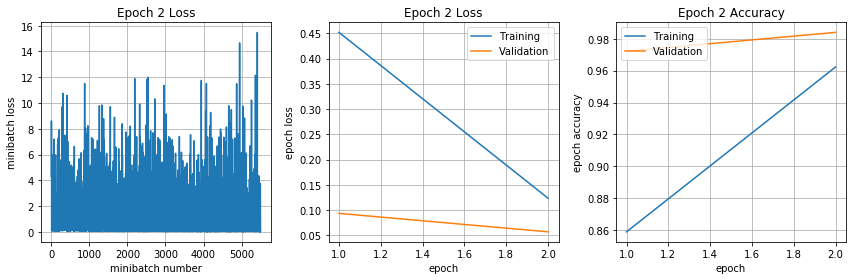

Iteration 11000: with minibatch training loss = 0.00141 and accuracy of 1
Iteration 11100: with minibatch training loss = 0.17 and accuracy of 0.9
Iteration 11200: with minibatch training loss = 0.0051 and accuracy of 1
Iteration 11300: with minibatch training loss = 0.708 and accuracy of 0.8
Iteration 11400: with minibatch training loss = 0.067 and accuracy of 1
Iteration 11500: with minibatch training loss = 0.179 and accuracy of 0.8
Iteration 11600: with minibatch training loss = 0.0156 and accuracy of 1
Iteration 11700: with minibatch training loss = 0.00846 and accuracy of 1
Iteration 11800: with minibatch training loss = 0.131 and accuracy of 0.9
Iteration 11900: with minibatch training loss = 0.0354 and accuracy of 1
Iteration 12000: with minibatch training loss = 0.35 and accuracy of 0.9
Iteration 12100: with minibatch training loss = 0.223 and accuracy of 0.9
Iteration 12200: with minibatch training loss = 0.0167 and accuracy of 1
Iteration 12300: with minibatch training loss 

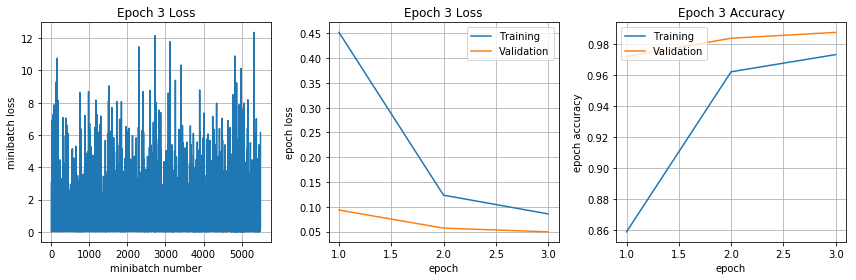

Iteration 16500: with minibatch training loss = 0.0113 and accuracy of 1
Iteration 16600: with minibatch training loss = 0.1 and accuracy of 0.9
Iteration 16700: with minibatch training loss = 0.00276 and accuracy of 1
Iteration 16800: with minibatch training loss = 0.132 and accuracy of 1
Iteration 16900: with minibatch training loss = 0.00219 and accuracy of 1
Iteration 17000: with minibatch training loss = 0.0129 and accuracy of 1
Iteration 17100: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 17200: with minibatch training loss = 0.0359 and accuracy of 1
Iteration 17300: with minibatch training loss = 0.014 and accuracy of 1
Iteration 17400: with minibatch training loss = 0.03 and accuracy of 1
Iteration 17500: with minibatch training loss = 0.00603 and accuracy of 1
Iteration 17600: with minibatch training loss = 0.0045 and accuracy of 1
Iteration 17700: with minibatch training loss = 0.00341 and accuracy of 1
Iteration 17800: with minibatch training loss = 0.41

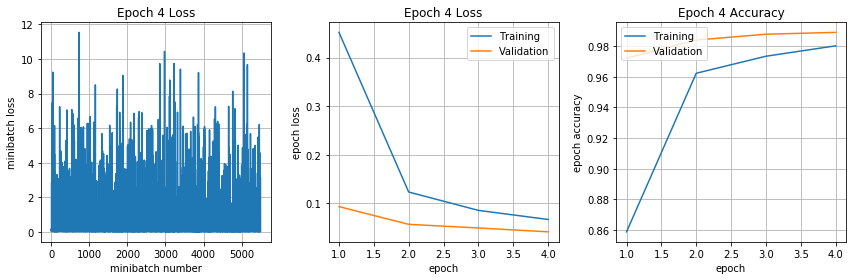

Iteration 22000: with minibatch training loss = 0.00867 and accuracy of 1
Iteration 22100: with minibatch training loss = 0.0128 and accuracy of 1
Iteration 22200: with minibatch training loss = 0.0209 and accuracy of 1
Iteration 22300: with minibatch training loss = 0.0286 and accuracy of 1
Iteration 22400: with minibatch training loss = 0.00205 and accuracy of 1
Iteration 22500: with minibatch training loss = 0.0106 and accuracy of 1
Iteration 22600: with minibatch training loss = 0.0784 and accuracy of 0.9
Iteration 22700: with minibatch training loss = 0.00227 and accuracy of 1
Iteration 22800: with minibatch training loss = 0.00945 and accuracy of 1
Iteration 22900: with minibatch training loss = 0.0463 and accuracy of 1
Iteration 23000: with minibatch training loss = 0.261 and accuracy of 0.9
Iteration 23100: with minibatch training loss = 0.00594 and accuracy of 1
Iteration 23200: with minibatch training loss = 0.00393 and accuracy of 1
Iteration 23300: with minibatch training l

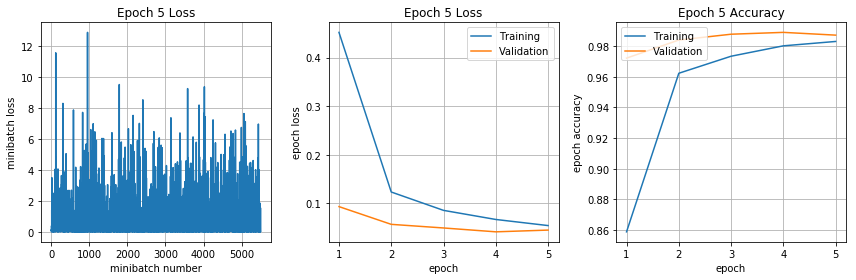

Iteration 27500: with minibatch training loss = 0.0219 and accuracy of 1
Iteration 27600: with minibatch training loss = 0.00974 and accuracy of 1
Iteration 27700: with minibatch training loss = 0.00349 and accuracy of 1
Iteration 27800: with minibatch training loss = 0.095 and accuracy of 1
Iteration 27900: with minibatch training loss = 0.0518 and accuracy of 1
Iteration 28000: with minibatch training loss = 0.0376 and accuracy of 1
Iteration 28100: with minibatch training loss = 0.00281 and accuracy of 1
Iteration 28200: with minibatch training loss = 0.487 and accuracy of 0.8
Iteration 28300: with minibatch training loss = 0.00136 and accuracy of 1
Iteration 28400: with minibatch training loss = 0.00386 and accuracy of 1
Iteration 28500: with minibatch training loss = 0.019 and accuracy of 1
Iteration 28600: with minibatch training loss = 0.111 and accuracy of 1
Iteration 28700: with minibatch training loss = 0.00128 and accuracy of 1
Iteration 28800: with minibatch training loss =

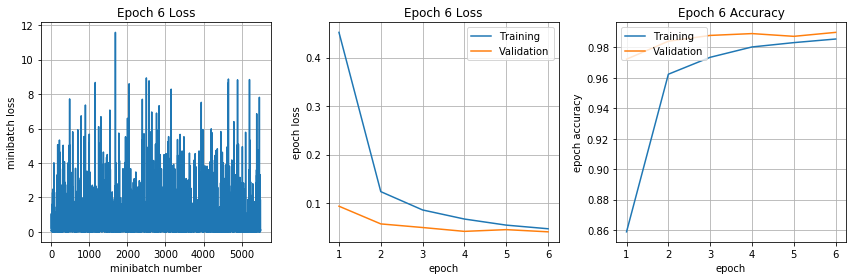

Iteration 33000: with minibatch training loss = 0.053 and accuracy of 1
Iteration 33100: with minibatch training loss = 0.156 and accuracy of 0.9
Iteration 33200: with minibatch training loss = 0.032 and accuracy of 1
Iteration 33300: with minibatch training loss = 0.00721 and accuracy of 1
Iteration 33400: with minibatch training loss = 0.000356 and accuracy of 1
Iteration 33500: with minibatch training loss = 0.0751 and accuracy of 1
Iteration 33600: with minibatch training loss = 0.000438 and accuracy of 1
Iteration 33700: with minibatch training loss = 0.0198 and accuracy of 1
Iteration 33800: with minibatch training loss = 0.00834 and accuracy of 1
Iteration 33900: with minibatch training loss = 0.00183 and accuracy of 1
Iteration 34000: with minibatch training loss = 0.0134 and accuracy of 1
Iteration 34100: with minibatch training loss = 0.000552 and accuracy of 1
Iteration 34200: with minibatch training loss = 0.128 and accuracy of 0.9
Iteration 34300: with minibatch training l

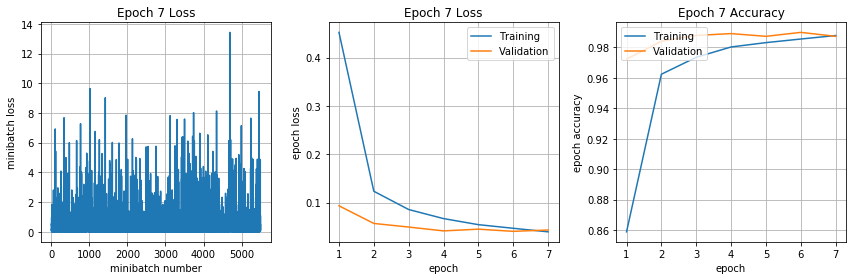

Iteration 38500: with minibatch training loss = 0.00306 and accuracy of 1
Iteration 38600: with minibatch training loss = 0.00896 and accuracy of 1
Iteration 38700: with minibatch training loss = 0.00167 and accuracy of 1
Iteration 38800: with minibatch training loss = 0.00526 and accuracy of 1
Iteration 38900: with minibatch training loss = 0.00423 and accuracy of 1
Iteration 39000: with minibatch training loss = 0.00513 and accuracy of 1
Iteration 39100: with minibatch training loss = 0.00513 and accuracy of 1
Iteration 39200: with minibatch training loss = 0.0259 and accuracy of 1
Iteration 39300: with minibatch training loss = 0.00264 and accuracy of 1
Iteration 39400: with minibatch training loss = 0.0144 and accuracy of 1
Iteration 39500: with minibatch training loss = 0.0027 and accuracy of 1
Iteration 39600: with minibatch training loss = 0.0184 and accuracy of 1
Iteration 39700: with minibatch training loss = 0.00315 and accuracy of 1
Iteration 39800: with minibatch training l

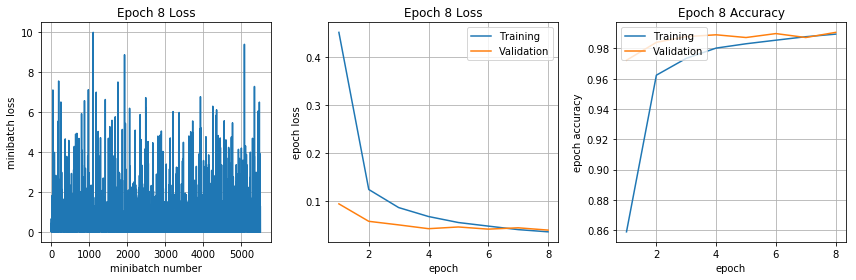

Iteration 44000: with minibatch training loss = 0.000444 and accuracy of 1
Iteration 44100: with minibatch training loss = 0.0105 and accuracy of 1
Iteration 44200: with minibatch training loss = 0.000923 and accuracy of 1
Iteration 44300: with minibatch training loss = 0.0129 and accuracy of 1
Iteration 44400: with minibatch training loss = 0.123 and accuracy of 0.9
Iteration 44500: with minibatch training loss = 0.000762 and accuracy of 1
Iteration 44600: with minibatch training loss = 0.00843 and accuracy of 1
Iteration 44700: with minibatch training loss = 0.0034 and accuracy of 1
Iteration 44800: with minibatch training loss = 0.00457 and accuracy of 1
Iteration 44900: with minibatch training loss = 0.00233 and accuracy of 1
Iteration 45000: with minibatch training loss = 0.00578 and accuracy of 1
Iteration 45100: with minibatch training loss = 0.000197 and accuracy of 1
Iteration 45200: with minibatch training loss = 0.000296 and accuracy of 1
Iteration 45300: with minibatch trai

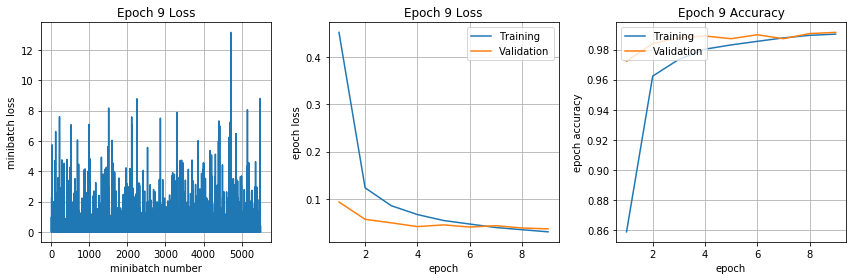

Iteration 49500: with minibatch training loss = 0.000547 and accuracy of 1
Iteration 49600: with minibatch training loss = 0.00309 and accuracy of 1
Iteration 49700: with minibatch training loss = 0.311 and accuracy of 0.9
Iteration 49800: with minibatch training loss = 0.00392 and accuracy of 1
Iteration 49900: with minibatch training loss = 0.00252 and accuracy of 1
Iteration 50000: with minibatch training loss = 0.000465 and accuracy of 1
Iteration 50100: with minibatch training loss = 0.000773 and accuracy of 1
Iteration 50200: with minibatch training loss = 0.0259 and accuracy of 1
Iteration 50300: with minibatch training loss = 0.0147 and accuracy of 1
Iteration 50400: with minibatch training loss = 0.0128 and accuracy of 1
Iteration 50500: with minibatch training loss = 0.00171 and accuracy of 1
Iteration 50600: with minibatch training loss = 0.0976 and accuracy of 0.9
Iteration 50700: with minibatch training loss = 0.00597 and accuracy of 1
Iteration 50800: with minibatch train

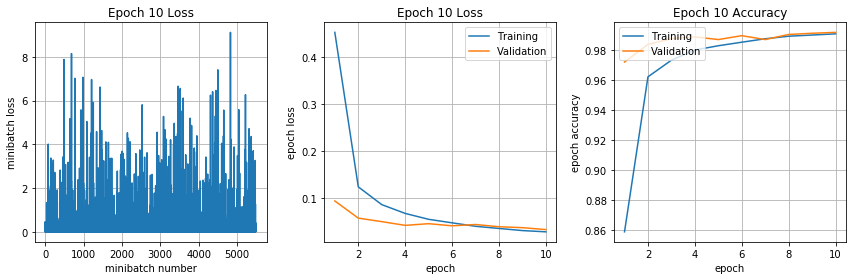

Iteration 55000: with minibatch training loss = 0.00076 and accuracy of 1
Iteration 55100: with minibatch training loss = 0.00326 and accuracy of 1
Iteration 55200: with minibatch training loss = 0.000145 and accuracy of 1
Iteration 55300: with minibatch training loss = 0.00151 and accuracy of 1
Iteration 55400: with minibatch training loss = 0.000108 and accuracy of 1
Iteration 55500: with minibatch training loss = 0.023 and accuracy of 1
Iteration 55600: with minibatch training loss = 0.000927 and accuracy of 1
Iteration 55700: with minibatch training loss = 0.000207 and accuracy of 1
Iteration 55800: with minibatch training loss = 0.000247 and accuracy of 1
Iteration 55900: with minibatch training loss = 0.00313 and accuracy of 1
Iteration 56000: with minibatch training loss = 0.000424 and accuracy of 1
Iteration 56100: with minibatch training loss = 0.00443 and accuracy of 1
Iteration 56200: with minibatch training loss = 0.000648 and accuracy of 1
Iteration 56300: with minibatch t

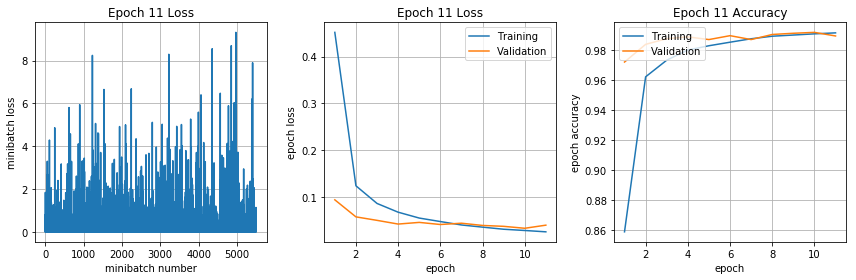

Iteration 60500: with minibatch training loss = 0.000347 and accuracy of 1
Iteration 60600: with minibatch training loss = 3.9e-05 and accuracy of 1
Iteration 60700: with minibatch training loss = 0.0973 and accuracy of 0.9
Iteration 60800: with minibatch training loss = 0.00603 and accuracy of 1
Iteration 60900: with minibatch training loss = 0.00233 and accuracy of 1
Iteration 61000: with minibatch training loss = 0.00154 and accuracy of 1
Iteration 61100: with minibatch training loss = 0.00195 and accuracy of 1
Iteration 61200: with minibatch training loss = 0.000737 and accuracy of 1
Iteration 61300: with minibatch training loss = 0.00122 and accuracy of 1
Iteration 61400: with minibatch training loss = 0.087 and accuracy of 0.9
Iteration 61500: with minibatch training loss = 0.000704 and accuracy of 1
Iteration 61600: with minibatch training loss = 0.000823 and accuracy of 1
Iteration 61700: with minibatch training loss = 0.000619 and accuracy of 1
Iteration 61800: with minibatch 

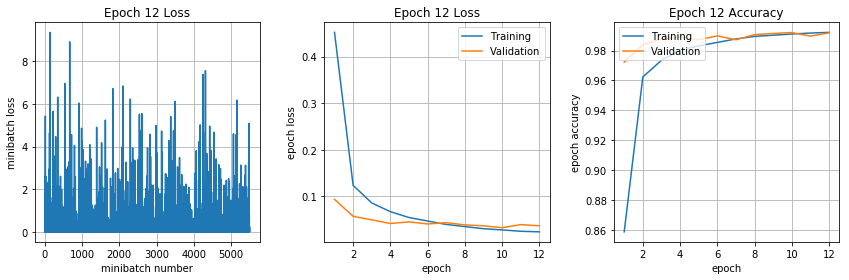

Iteration 66000: with minibatch training loss = 0.000981 and accuracy of 1
Iteration 66100: with minibatch training loss = 0.000681 and accuracy of 1
Iteration 66200: with minibatch training loss = 0.00282 and accuracy of 1
Iteration 66300: with minibatch training loss = 0.000207 and accuracy of 1
Iteration 66400: with minibatch training loss = 0.00124 and accuracy of 1
Iteration 66500: with minibatch training loss = 0.00259 and accuracy of 1
Iteration 66600: with minibatch training loss = 0.0264 and accuracy of 1
Iteration 66700: with minibatch training loss = 0.107 and accuracy of 1
Iteration 66800: with minibatch training loss = 0.298 and accuracy of 0.8
Iteration 66900: with minibatch training loss = 6.92e-05 and accuracy of 1
Iteration 67000: with minibatch training loss = 0.000145 and accuracy of 1
Iteration 67100: with minibatch training loss = 0.000751 and accuracy of 1
Iteration 67200: with minibatch training loss = 0.00177 and accuracy of 1
Iteration 67300: with minibatch tra

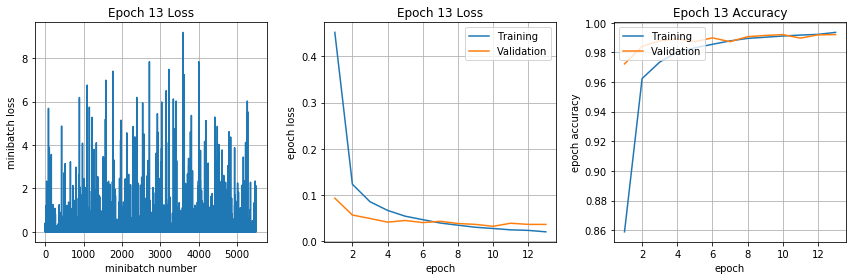

Iteration 71500: with minibatch training loss = 0.000932 and accuracy of 1
Iteration 71600: with minibatch training loss = 0.00552 and accuracy of 1
Iteration 71700: with minibatch training loss = 0.00047 and accuracy of 1
Iteration 71800: with minibatch training loss = 0.000738 and accuracy of 1
Iteration 71900: with minibatch training loss = 0.00652 and accuracy of 1
Iteration 72000: with minibatch training loss = 0.000132 and accuracy of 1
Iteration 72100: with minibatch training loss = 0.00015 and accuracy of 1
Iteration 72200: with minibatch training loss = 0.000476 and accuracy of 1
Iteration 72300: with minibatch training loss = 0.000114 and accuracy of 1
Iteration 72400: with minibatch training loss = 0.00162 and accuracy of 1
Iteration 72500: with minibatch training loss = 0.00248 and accuracy of 1
Iteration 72600: with minibatch training loss = 0.0132 and accuracy of 1
Iteration 72700: with minibatch training loss = 0.0169 and accuracy of 1
Iteration 72800: with minibatch tra

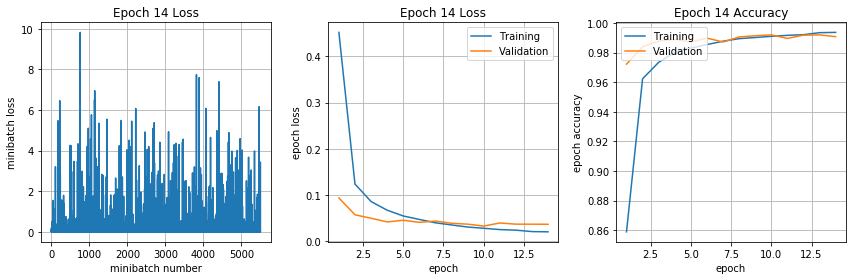

Iteration 77000: with minibatch training loss = 0.000483 and accuracy of 1
Iteration 77100: with minibatch training loss = 0.000184 and accuracy of 1
Iteration 77200: with minibatch training loss = 0.00177 and accuracy of 1
Iteration 77300: with minibatch training loss = 0.0806 and accuracy of 1
Iteration 77400: with minibatch training loss = 0.0856 and accuracy of 0.9
Iteration 77500: with minibatch training loss = 0.000967 and accuracy of 1
Iteration 77600: with minibatch training loss = 0.00107 and accuracy of 1
Iteration 77700: with minibatch training loss = 0.000205 and accuracy of 1
Iteration 77800: with minibatch training loss = 0.000135 and accuracy of 1
Iteration 77900: with minibatch training loss = 2.6e-05 and accuracy of 1
Iteration 78000: with minibatch training loss = 0.00201 and accuracy of 1
Iteration 78100: with minibatch training loss = 0.000385 and accuracy of 1
Iteration 78200: with minibatch training loss = 0.000966 and accuracy of 1
Iteration 78300: with minibatch

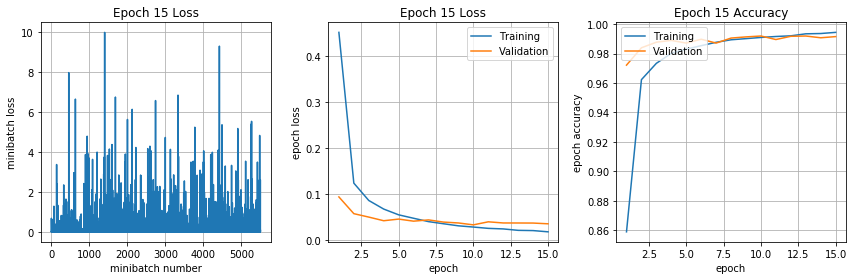

In [9]:
num_train = 1000
X_train_small= tf.to_float(X_train[:num_train], name='ToFloat')
y_train_small= tf.to_float(y_train[:num_train], name='ToFloat')

sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')

[loss,correct, loss_val,correct_val]=run_model(session=sess, predict=y_out, loss_val=mean_loss, Xd=X_train, yd=y_train,
                                               epochs=15, batch_size=10, print_every=100, training=train_step, 
                                               plot_losses=True, X_val=X_val,y_val=y_val)

In [11]:
saver = tf.train.Saver()
save_path = saver.save(sess, "model/MNIST_model_small2.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: model/MNIST_model_small2.ckpt
